In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import glob
import geopandas as gpd
import contextily as cx
import xarray as xr
import seaborn as sns
from matplotlib.lines import Line2D


In [2]:
def set_xy_labels(xlabel, ylabel, xpad = None, ypad = None):
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

    plt.xlabel(xlabel,labelpad = xpad)
    plt.ylabel(ylabel, labelpad = ypad)
def legend_element(color, label, size = 15):
    return Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=size)

In [3]:
london = gpd.read_file('/home/dan/Downloads/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
#uk_regions = gpd.read_file('ukcp18-uk-land-region-hires.shp')

## Getting data regarding site locations

In [4]:
df_site_abbrev = pd.read_csv('site_abbreviations.csv')
df_site_abbrev.dropna(inplace=True)
print(f'num sites: {len(df_site_abbrev)}')

df_site_locations = pd.read_csv('site_locations.csv')
print(f'num sites: {len(df_site_locations)}')

df_site_locations.head(10)


num sites: 133
num sites: 131


station    classification   road_distance  \
0      Barking and Dagenham - Rush Green          Suburban  Not applicable   
1  Barking and Dagenham - Scrattons Farm          Suburban  Not applicable   
2                     Bexley - Belvedere          Suburban  Not applicable   
3                Bexley - Belvedere West  Urban Background       50 metres   
4                   Bexley - Slade Green          Suburban   Not available   
5             Bexley - Slade Green Fidas          Suburban  Not applicable   
6   Brent - ARK Franklin Primary Academy          Roadside        3 metres   
7                           Brent - Ikea          Roadside   Not available   
8      Brent - John Keble Primary School          Roadside   Not available   
9                   Brent - Neasden Lane        Industrial  Not applicable   

          height   latitude  longitude  
0  Not available  51.563752   0.177891  
1  Not available  51.529389   0.132857  
2  Not available  51.490610   0.158914  
3       2 metres  51.494649   0.137279  
4       4 metres  51.465983   0.184877  
5  Not available  51.465983   0.184877  
6  Not available  51.532405  -0.217719  
7  Not available  51.552476  -0.258089  
8  Not available  51.537799  -0.247793  
9  Not available  51.552656  -0.248774

Note: We want to merge the two dataframes on the station column, since they are supposed to be identical. However, there is one station whose name is spelled differently between the two dataframes. This is due to someone forgetting a space when typing in the station name. Let's fix this.

In [5]:
df_site_abbrev.at[70,'station'] = 'Lewisham - Laurence House Catford'
#merge df_site_abbrev and df_site_locations
df_site_locations = df_site_locations.merge(df_site_abbrev, on = 'station')


### Clean dataframe to have NaN's. Also replace the height and road_distance with numerical values.

In [6]:
df_site_locations = df_site_locations.replace({'Not applicable': np.nan, 'Not available': np.nan})
def clean_distance(x):
    if isinstance(x,float):
        return x
    return float(x.replace(' metres',''))
df_site_locations['height'] = df_site_locations['height'].apply(clean_distance)
df_site_locations['road_distance'] = df_site_locations['road_distance'].apply(clean_distance)

classes = df_site_locations['classification'].unique()

### Let's look at the distribution of the different site types.

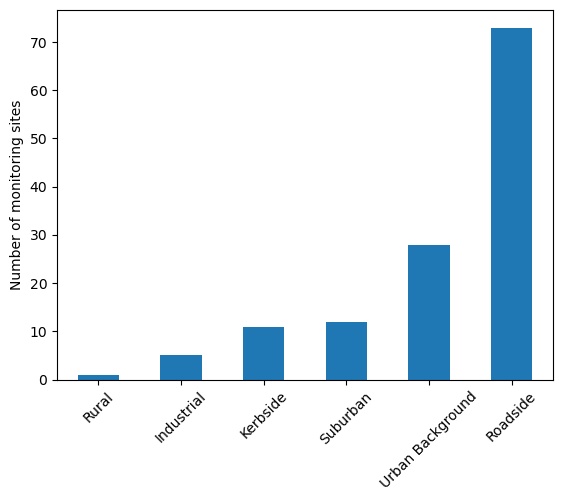

In [7]:
df_num_sites = df_site_locations.groupby('classification').station.count()
df_num_sites.name = 'site_number'

df_num_sites.sort_values().plot.bar(rot=45)
plt.xlabel('')
plt.ylabel('Number of monitoring sites');

### Monitoring sites mostly in urban areas or by roads. This makes sense, since we expect air pollution to be worst in these areas.

### Let's look at how many missing values there are for the road_distance and height attributes of the site monitors.

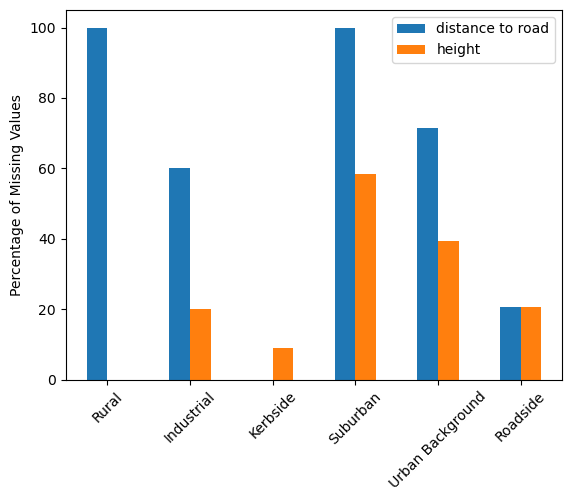

In [8]:
df_distance_nan = df_site_locations.road_distance.isnull().groupby(df_site_locations['classification']).agg(lambda x: 100*sum(x)/len(x))
df_height_nan = df_site_locations.height.isnull().groupby(df_site_locations['classification']).agg(lambda x: 100*sum(x)/len(x))

df_distance_nan.name = 'distance to road'
df_height_nan.name = 'height'

df_nan = pd.DataFrame(df_distance_nan).join([df_height_nan,df_num_sites])

df_nan.sort_values(by='site_number')[['distance to road', 'height']].plot.bar(rot = 45, ylabel = 'Percentage of Missing Values')
plt.xlabel('');

### Many missing values regarding how far a monitoring site is from a road, as well as how high off the ground the monitor is mounted. 

### This is especially true as we move away from roads and towards more suburban areas.

### Let's check out how far the site monitors are from the road.

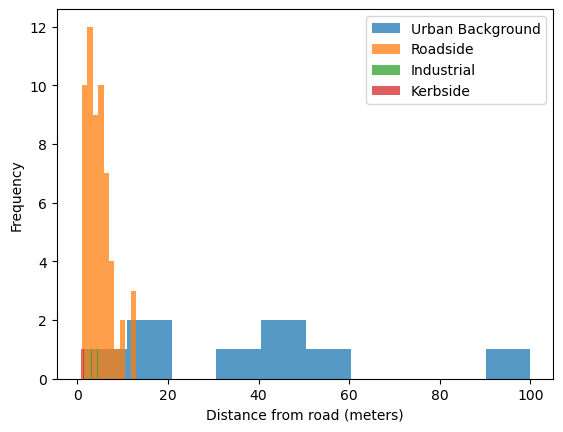

In [9]:
classes = df_site_locations['classification'].unique()

for class_ in classes:
    df_class = df_site_locations[df_site_locations['classification'] == class_]
    
    if df_class['road_distance'].notnull().sum()>0:
        
        df_class['road_distance'].plot.hist(label = class_, alpha = 0.75)


plt.xlabel('Distance from road (meters)')
plt.legend();


### Most roadside monitors are 4 to 5 meters from a road. Monitors near curbs and industrial sites are also close to the road. In contrast, there is a large variation in the "urban background" monitors, which exist up to ~100 meters away from the road.

### Here is the distribution telling us how high the site monitors are off the ground.

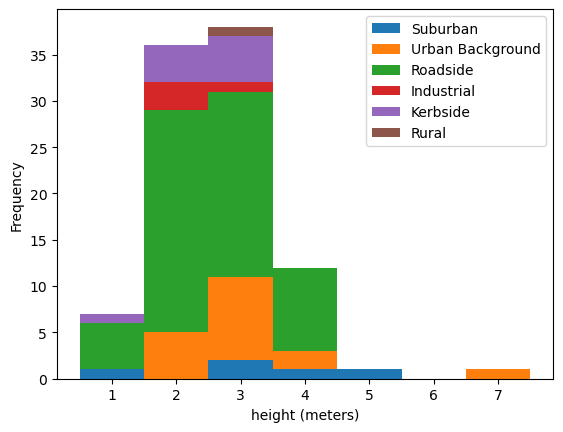

In [10]:
height_dfs = []

for class_ in classes:
    df_class = df_site_locations[df_site_locations['classification'] == class_]
    df_class = df_class['height'].dropna()
    
    height_dfs.append(pd.DataFrame(df_class.to_numpy(), columns = [class_]))
    
height_df = pd.concat(height_dfs, axis = 1)
height_df.plot.hist(stacked = True, bins = np.arange(0.5,8))
plt.xlabel('height (meters)')
plt.ylim()
plt.legend();

### Most of the air quality monitors are about 2 to 3 meters off the ground.

### Let's see how the air quality monitors are distributed around London.

In [11]:
gdf = gpd.GeoDataFrame(df_site_locations,
                       geometry = gpd.points_from_xy(df_site_locations.longitude, df_site_locations.latitude),
                       crs="EPSG:4326")
gdf = gdf.to_crs('EPSG:3857') #switch to web mercator coordinate system

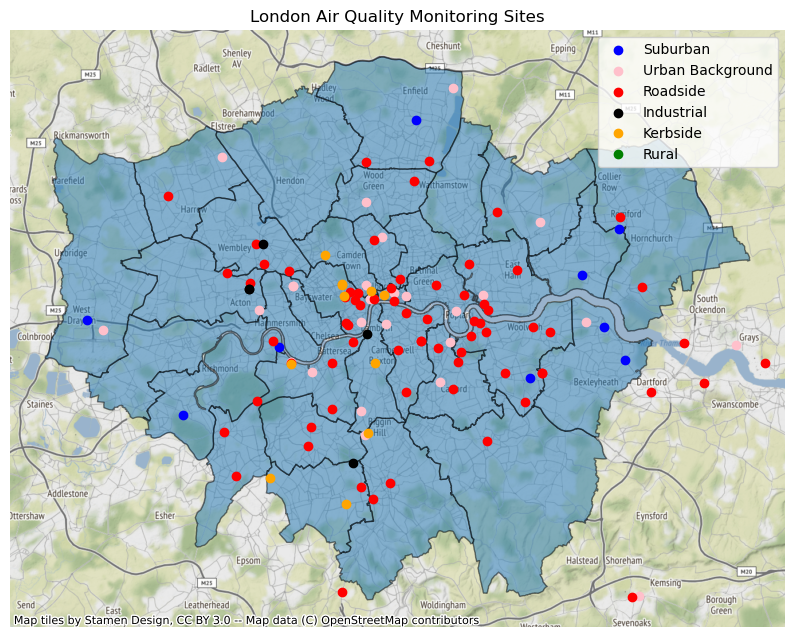

In [12]:
class_colors = {'Industrial': 'black',
                'Roadside': 'red',
                'Kerbside': 'orange',
                'Urban Background': 'pink',
                'Suburban': 'blue',
                'Rural': 'green'}

london_wm = london.to_crs(epsg = 3857) #switch to web mercator coordinate system
ax = london_wm.plot(figsize = (10,10), alpha = 0.5, edgecolor = 'k')
cx.add_basemap(ax)

for class_ in classes:
    gdf_class = gdf[gdf['classification'] == class_]
    gdf_class.plot(ax = ax, color = class_colors[class_], label = class_)

plt.legend()
plt.axis('off')
plt.title('London Air Quality Monitoring Sites')
plt.show()

### As one would expect, there is a higher density of monitoring sites near the center of London, which predominantly consist of roadside, urban background, and curbside monitors.

### The suburban sites exist farther away from the city center (on the order of 10s of kilometers.) The one rural site is a few kilometers to the south of the shown area.

## Let's aggregate the data from all of the sites into one dataframe

In [13]:
df_sites = {}

#count how many sites collect each type of measurement
measurement_dict = {}

for idx, row in df_site_abbrev.iterrows():
    site_abbrev, site_station = row
    df_list = []
    for f in glob.glob('{}*csv'.format(site_abbrev)):
        df = pd.read_csv(f)
        df_list.append(df)
        

    if df_list:
        df = pd.concat(df_list)
        df['site_station'] = site_station
        df['ReadingDateTime'] = pd.to_datetime(df['ReadingDateTime'], format='%d/%m/%Y %H:%M')
        df_sites[site_abbrev] = df
        print('Aggregating data for {}.'.format(site_station))
        
        #update measurement dict
        for measurement in df['Species'].unique():
            if measurement not in measurement_dict:
                measurement_dict[measurement] = 1
            else:
                measurement_dict[measurement] += 1
    else:
        print('No measurements available at {}!'.format(site_station))

Aggregating data for Barking and Dagenham - Rush Green.
Aggregating data for Barking and Dagenham - Scrattons Farm.
Aggregating data for Bexley - Belvedere.
Aggregating data for Bexley - Belvedere West.
Aggregating data for Bexley - Slade Green.
Aggregating data for Bexley - Slade Green FIDAS.
Aggregating data for Brent - ARK Franklin Primary Academy.
Aggregating data for Brent - Ikea.
Aggregating data for Brent - John Keble Primary School.
Aggregating data for Brent - Neasden Lane.
Aggregating data for Bromley - Harwood Avenue.
Aggregating data for Camden - Bloomsbury.
Aggregating data for Camden - Holborn (Bee Midtown).
Aggregating data for Camden - Swiss Cottage.
Aggregating data for City of London - Beech Street.
Aggregating data for City of London - Farringdon Street.
Aggregating data for City of London - Guildhall.
Aggregating data for City of London - The Aldgate School.
Aggregating data for City of London - Upper Thames Street.
Aggregating data for Croydon - Norbury.
Aggregatin

### Let's take a look at what measurements are taken at the monitoring sites.

In [14]:
print(measurement_dict.keys())

dict_keys(['BP', 'NO', 'NO2', 'NOX', 'RAIN', 'RHUM', 'SOLR', 'SO2', 'TMP', 'WDIR', 'WSPD', 'PM10', 'PM1', 'FINE', 'PM2.5', 'TSP', 'O3', 'CO', 'BENZ'])


## A dictionary of what each measurement means:

### Chemical measurements:

* #### BP: Barometric pressure (mbar)
* #### NO: Nitric oxide (ug/m3)
* #### NO2: Nitrogen dioxide (ug/m3)
* #### NOx: NO and NO2 (ug/m3)
* #### CO: Carbon monoxide (ug/m3)
* #### O3: Ozone (ug/m3)
* #### BENZ: Benzene (ug/m3)
* #### SO2: Sulfur dioxide (ug/m3)
* #### PM1: Particles less than 1 micron in size (from dust, bacteria, viruses)(ug/m3)
* #### PM2.5: Particles less than 2.5 microns in size (from combustion of gas, diesel, wood) (ug/m3)
* #### FINE: Seems to be another measurement of PM2.5
* #### PM10: Particles less than 10 microns in size (from dust arising from e.g. landfills, construction. can also arise from natural sources like pollen.) (ug/m3)
* #### TSP: Total suspended particulate (includes all particulate sizes) (ug/m3)

### Meteorological measurements:

* #### RAIN: Rainfall (mm)
* #### RHUM: Relative humidity (%)
* #### TMP: Temperature (C)
* #### WSPD: Wind speed (m/s)
* #### WDIR: Wind direction (oN)
* #### SOLR: Solar radiation (W/m2)

### Most sites only measure a small subset of these variables. Let's see how many sites measure each variable.

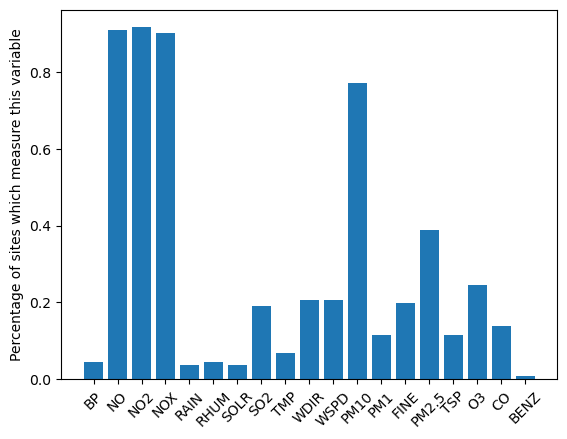

In [15]:
num_sites = len(df_sites)

plt.bar(measurement_dict.keys(),[i/num_sites for i in measurement_dict.values()])
plt.xticks(rotation=45)
plt.ylabel('Percentage of sites which measure this variable');

### Almost all the sites (more than 90%) measure NO, NO2, and NOx. However, very few sites measure the remaining variables. PM10 is also well-measured, with almost 80% of the sites measuring this. After PM10, only PM2.5 comes close, with only 40% of the sites measuring this.

### Let's look at how correlated the NOx and PM10 variables are.

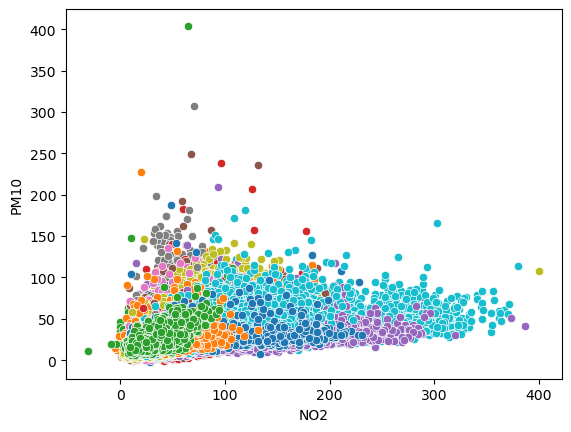

In [16]:
measurement1 = 'NO2'
measurement2 = 'PM10'

for df in df_sites.values():
    species = df['Species'].unique()
    if measurement1 in species and measurement2 in species:
        df_1 = df[df['Species'] == measurement1][['ReadingDateTime','Value']]
        df_1.rename(columns = {'ReadingDateTime': 'time', 'Value': measurement1}, inplace = True)
        df_1.set_index('time', inplace = True)

        df_2 = df[df['Species'] == measurement2][['ReadingDateTime','Value']]
        df_2.rename(columns = {'ReadingDateTime': 'time', 'Value': measurement2}, inplace = True)
        df_2.set_index('time', inplace = True)

        # match time stamps for a given site.
        df_both = df_1.join(df_2)

        sns.scatterplot(x = measurement1, y = measurement2, data = df_both);

From this, we see that PM10 and NO2 are generally positively correlated for all of the sites. The same holds for pollutants other than PM10 (e.g. PM2.5). However, NO2 varies significantly more than PM10 does. 

This fact is well-known, and reflects the strong spatial inhomogeneity of NO2, which is highly correlated to traffic.

Since NO2 is the most widely measured pollutant, we will restrict our forecasting to this variable.

In [17]:
df_sites_NO2 = {}

for site, df in df_sites.items():
    if 'NO2' in df['Species'].unique():
        #throw away non-NO2 variables
        df = df[df['Species'] == 'NO2']
        df_sites_NO2[site] = df
        
print('Number of sites which measure NO2: {}'.format(len(df_sites_NO2.keys())))

Number of sites which measure NO2: 120


Now, let's look to see if there are any strange values for the NO2 concentration.

In [18]:
for site, df in df_sites_NO2.items():
    num_zeros = df[df['Value'] == 0]['Value'].count()
    num_neg = df[df['Value'] < 0]['Value'].count()
    if num_zeros > 0 or num_neg > 0:
        print()
        print(df.site_station.unique()[0])
    if num_zeros > 0:
        print('Number of zero values at {}: {}'.format(site,num_zeros))
    if num_neg > 0:
        print('Number of negative values at {}: {}'.format(site,num_neg))        
    #df['Value'].plot.hist(alpha = 0.7)


Barking and Dagenham - Rush Green
Number of negative values at BG1: 2

Bexley - Belvedere
Number of negative values at BX2: 2

Bexley - Belvedere West
Number of negative values at BQ7: 1

City of London - Farringdon Street
Number of zero values at CT2: 15

Enfield - Bush Hill Park
Number of negative values at EN1: 1

Greenwich - Westhorne Avenue
Number of zero values at GR9: 1

Haringey - Haringey Town Hall
Number of zero values at HG1: 1

Reading - New Town
Number of zero values at RD0: 4

Reigate and Banstead - Poles Lane
Number of negative values at RG3: 1

Wandsworth - Battersea
Number of negative values at WAA: 4

Windsor and Maidenhead - Frascati Way
Number of negative values at MW1: 3


From this, we see that some of the NO2 concentrations are negative, while others are exactly zero. The negative NO2 concentrations can also be seen from the previous plot.

Regarding the negative values, this is because of the "Method Detection Limit" or MDL. This quantity is defined (in the US) as the minimum concentration that one can definitively (with 99% confidence) say is different from zero. Here, we will set these negative values to zero.

Regarding the zero-concentration values, these most likely represent sensor failures, and we will replace these zeros with NaN's.

In [19]:
for site, df in df_sites_NO2.items():
    df2 = df.copy()
    df2.loc[df['Value'] == 0, 'Value'] = np.nan
    df2.loc[:,'Value'] = df['Value'].clip(lower = 0)
    df_sites_NO2[site] = df2

Let's now look at the distribution of NO2 values for the different site types (road, urban background, etc.)

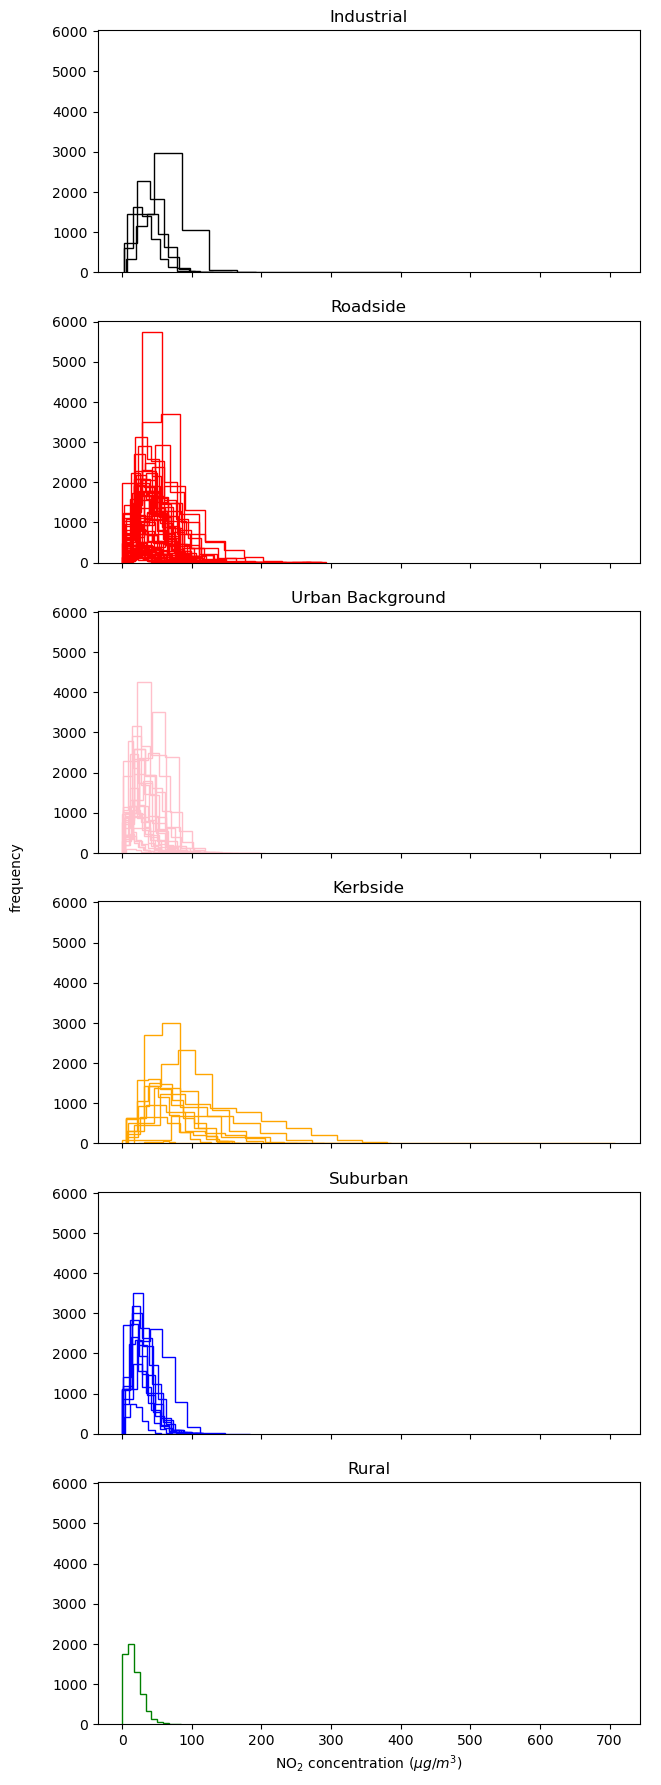

In [20]:


class_colors = {'Industrial': 'black',
                'Roadside': 'red',
                'Urban Background': 'pink',
                'Kerbside': 'orange',
                'Suburban': 'blue',
                'Rural': 'green'}

fig, ax = plt.subplots(nrows = len(class_colors), ncols = 1, figsize = (7,22), sharex = True, sharey = True)


legend_elements = [legend_element(color,label) for label, color in class_colors.items()]

for site, df in df_sites_NO2.items():
    class_ = df_site_locations.loc[df_site_locations['abbreviation'] == site,'classification'].values[0]
    idx = list(class_colors.keys()).index(class_)
    df_plot = df['Value'].dropna()
    if df['Value'].notnull().count() > 0:
        ax[idx].hist(df_plot, facecolor = 'None', edgecolor = class_colors[class_], histtype = 'step')
        
for idx, class_ in enumerate(class_colors.keys()):
    ax[idx].set_title(class_)
    
set_xy_labels('NO$_2$ concentration ($\mu g/m^3$)','frequency', ypad = 30)

From the above histograms, we see that the distribution of NO2 values can be quite different between the various classes.

Let's take a look at one of the time series.

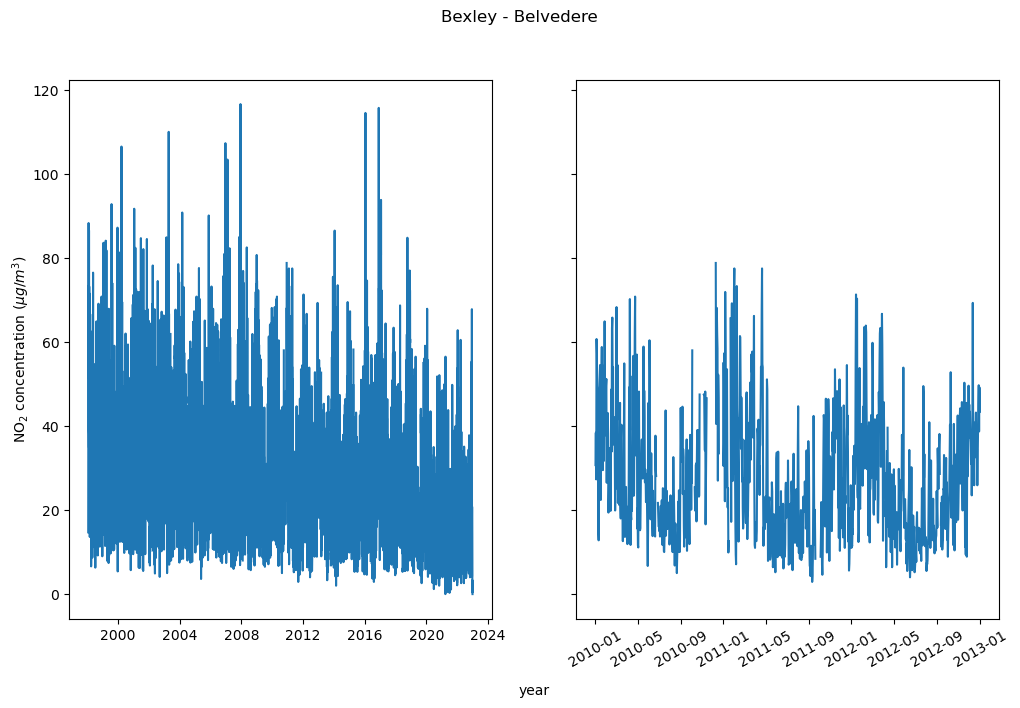

In [21]:
site_abbrev = 'BX2'

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,7), sharey = True)

df_test = df_sites_NO2[site_abbrev]
ax[0].plot(df_test['ReadingDateTime'],df_test['Value'])

t1 = datetime.datetime.strptime('2010/01/01','%Y/%m/%d')
t2 = datetime.datetime.strptime('2013/01/01','%Y/%m/%d')
df_12_test = df_test[(df_test['ReadingDateTime'] >= t1) & (df_test['ReadingDateTime'] <= t2)]

ax[1].plot(df_12_test['ReadingDateTime'],df_12_test['Value'])

plt.setp(ax[1].get_xticklabels(), rotation = 30)

plt.suptitle(df_sites_NO2[site_abbrev]['site_station'].unique()[0]);
set_xy_labels('year', 'NO$_2$ concentration ($\mu g/m^3$)', xpad = 30)

On the left, we have plotted the entire time series for this site. On the right, we have added a zoomed-in version, highlighting the seasonal variation in the NO2 concentration from year to year. This variation is especially clear when looking at the Fourier transform, which we show below.

Note: To perform the Fourier transform, we cannot have missing values. Here, the missing values in this time series are imputed by simple linear interpolation between the two time points. This does not qualitatively change where the peaks in the Fourier transform are.

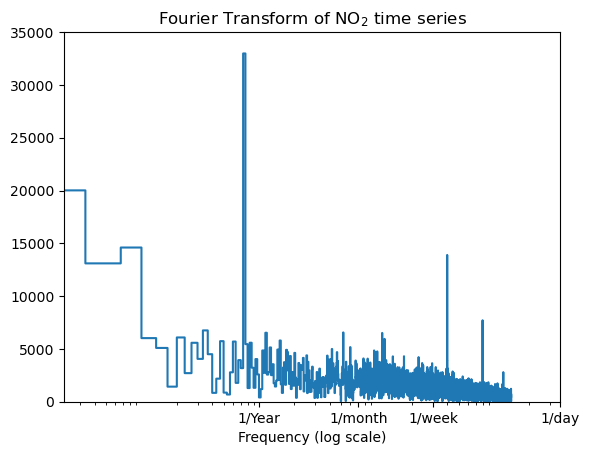

In [22]:
site_abbrev = 'BX2'
df_test = df_sites_NO2[site_abbrev]
t1 = datetime.datetime.strptime('2000/01/01','%Y/%m/%d')
t2 = datetime.datetime.strptime('2023/01/01','%Y/%m/%d')
df_12_test = df_test[(df_test['ReadingDateTime'] >= t1) & (df_test['ReadingDateTime'] <= t2)]
data = df_12_test['Value'].interpolate(method = 'linear').to_numpy()
fft = np.fft.rfft(data)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_test['Value'])
days_per_year = 365.2524
years_per_dataset = n_samples_h/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 3.5e4)

#plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524/52,365.2524/12,365.2524], labels=['1/Year', '1/month','1/week' ,'1/day'])
plt.xlabel('Frequency (log scale)')
plt.title('Fourier Transform of NO$_2$ time series');

From the above Fourier transform, we see that the time series has periodic variations on time scales of around a year, and also around a week. 

The yearly variation likely comes from multiple sources: winter holidays like Christmas, and also the fact that people probably drive more when the weather is colder. The weekly variation comes from the difference in traffic between weekdays and weekends.

For a given site and measurement (e.g. NO2), there can be quite a few missing values. Here, we show the time series of NO2 for some monitoring sites over the span of 20 years (from 2000 to 2020).

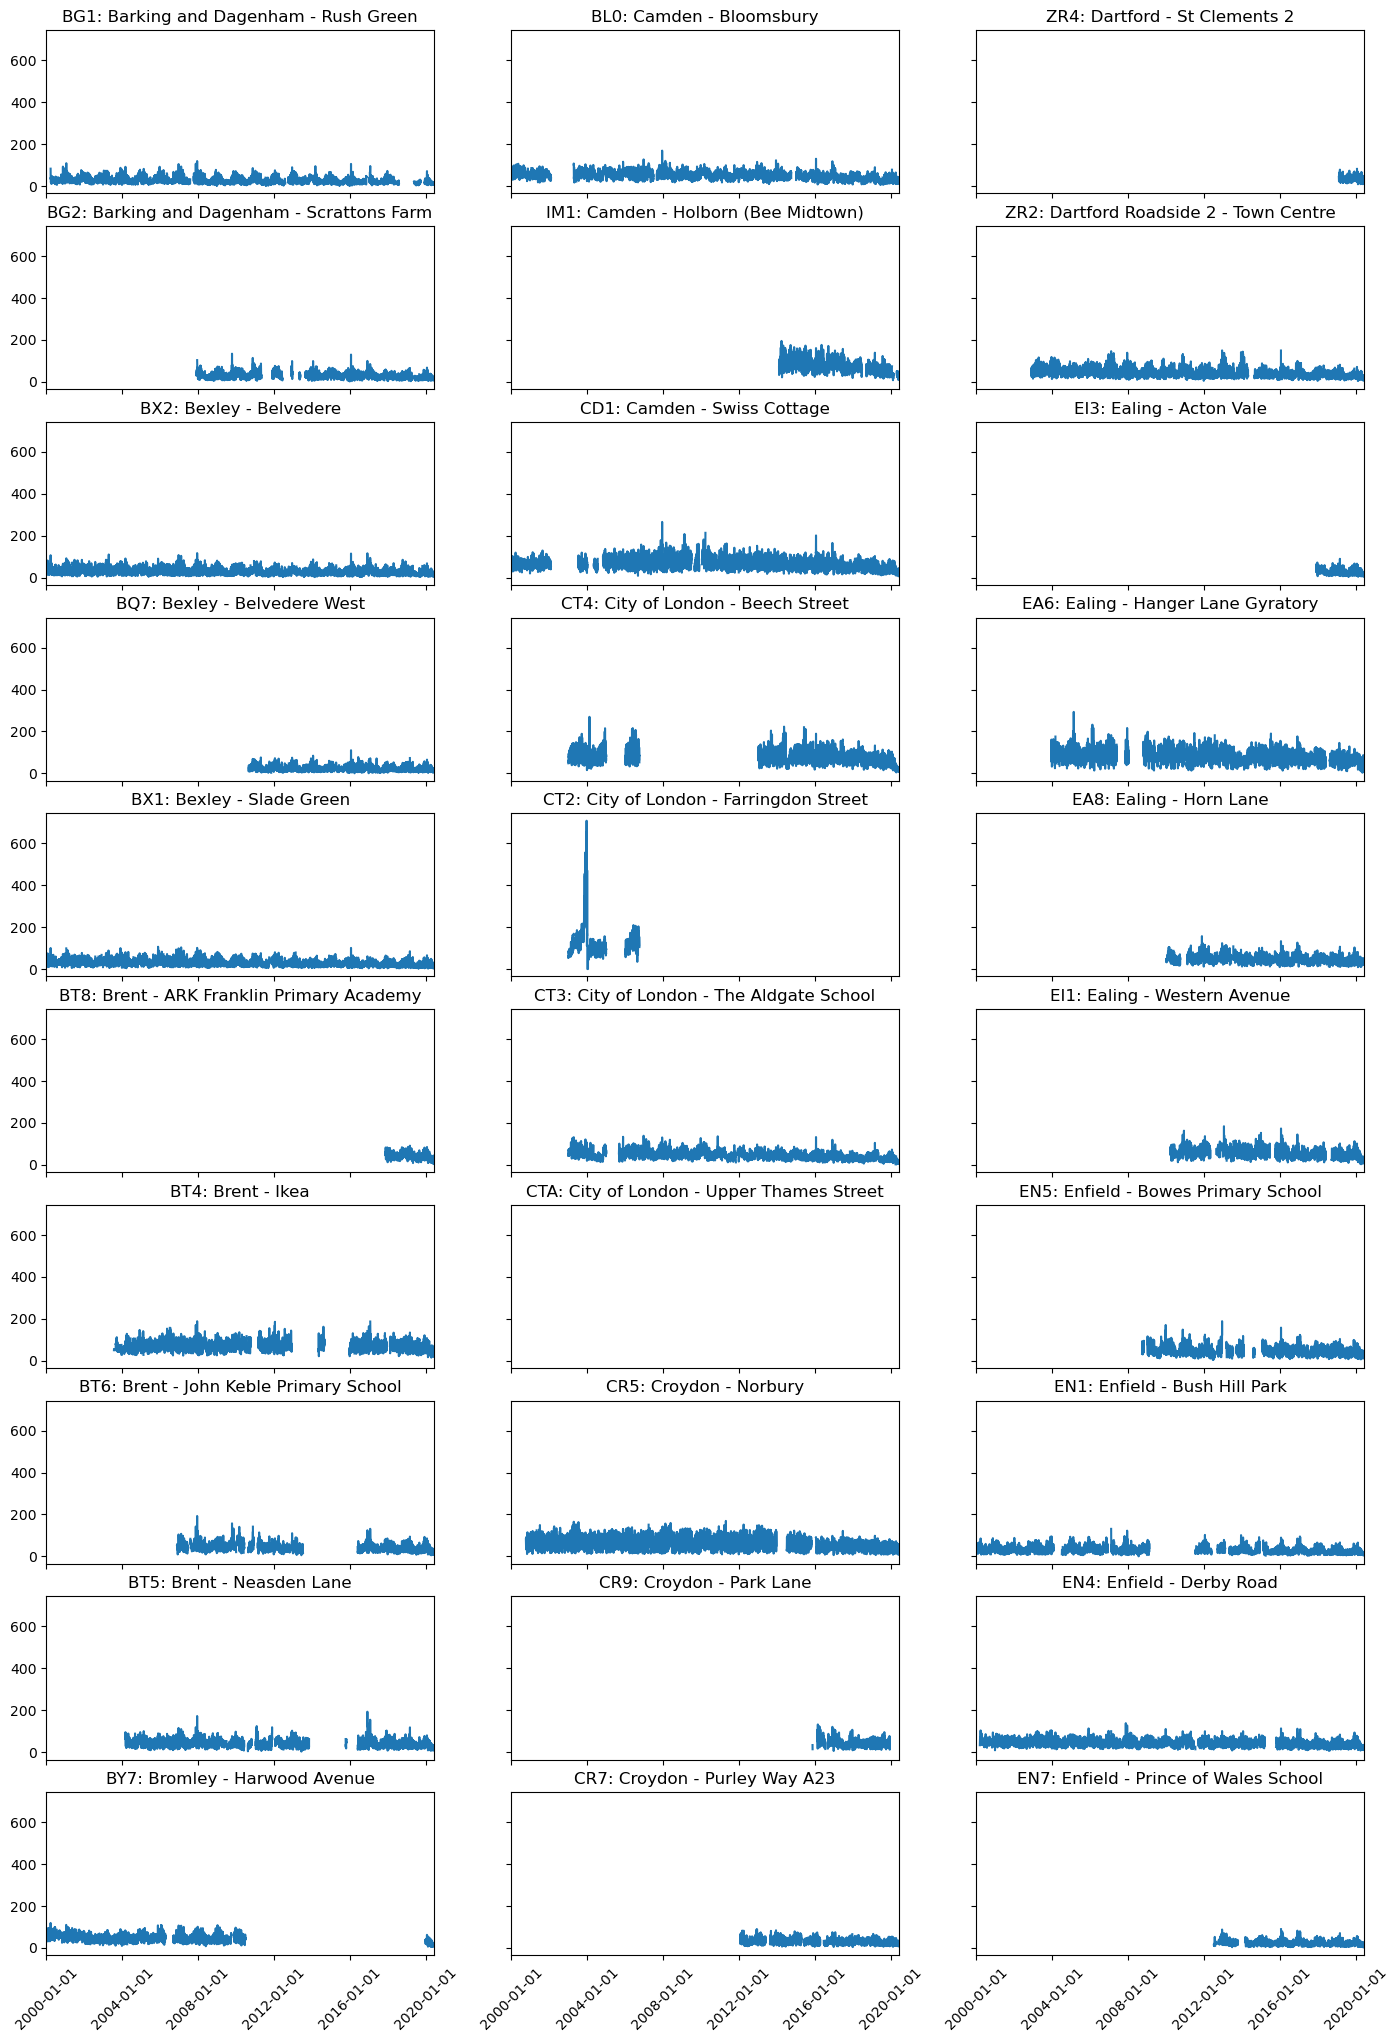

In [23]:
nrows = 10
ncols = 3
max_sites = nrows * ncols

t1 = datetime.datetime.strptime('2000/01/01','%Y/%m/%d')
t2 = datetime.datetime.strptime('2020/06/01','%Y/%m/%d')

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize = (17,25))

site_idx = 0

for site, df in df_sites_NO2.items():
    row = site_idx % nrows
    col = site_idx // nrows
    ax[row,col].plot(df['ReadingDateTime'],df['Value'])
    ticks = ax[row,col].get_xticks()
    labels = ax[row,col].get_xticklabels()
    plt.setp(labels,rotation=45)
    ax[row,col].set_xticks(ticks)
    ax[row,col].set_xlim(t1,t2)
    ax[row,col].set_title('{}: {}'.format(site,df['site_station'].unique()[0]))
    
    
    
    site_idx += 1
    if site_idx == max_sites:
        break

plt.setp(labels,rotation=45);





Note the extremely large values for Farringdon Street in the City of London. This site (other than missing most of its NO2 values) has an absurdly large value for its NO2 concentration, that lasted for months. 

Upon a quick google, Farringdon street is a notoriously heavy-traffic street. This might suggest that the high pollution values seen here are real.

However, the fact that this peak is not seen at any other site at the same time suggests that this is an equipment malfunction. This would also explain why there are so many missing values in the Farringdon street time series.

To deal with this, we will cull sites with too many values. We will also look and deal with outliers.

Let's see the distribution detailing how many missing values there are between certain dates.

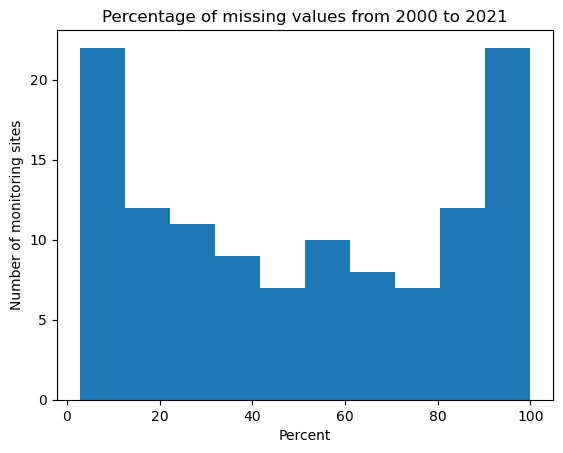

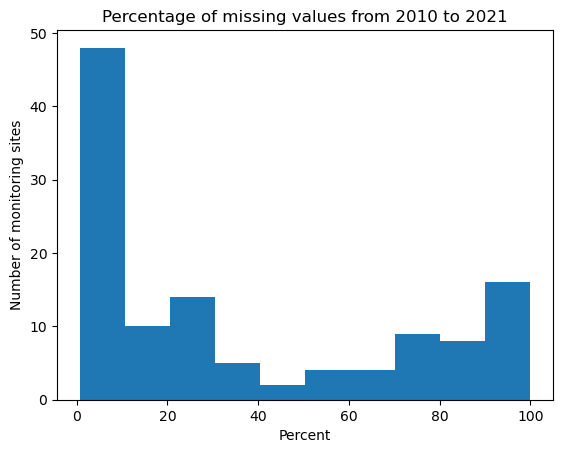

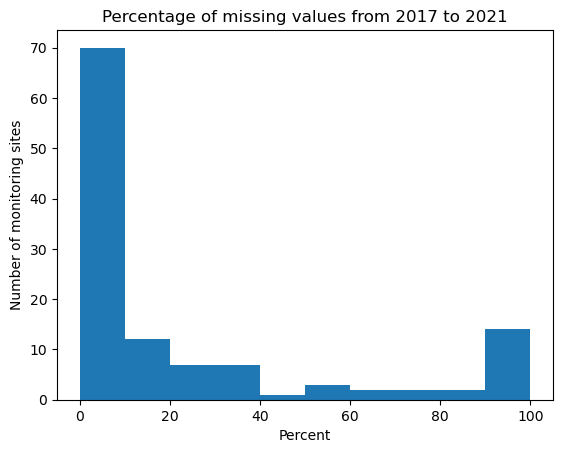

In [24]:
def plot_nan_percent(df_sites, year1, year2):
    t1 = datetime.datetime.strptime('{}/01/01'.format(year1),'%Y/%m/%d')
    t2 = datetime.datetime.strptime('{}/01/01'.format(year2),'%Y/%m/%d')
    percent_nan_list = []

    for site, df in df_sites.items():
        df_in_timeframe = df[(df['ReadingDateTime'] >= t1)& (df['ReadingDateTime'] <= t2)]
        percent_nan = df_in_timeframe['Value'].isnull().sum()/len(df_in_timeframe)*100
        percent_nan_list.append(percent_nan)
        
    plt.hist(percent_nan_list)
    plt.xlabel('Percent')
    plt.title('Percentage of missing values from {} to {}'.format(year1,year2))
    plt.ylabel('Number of monitoring sites')
    plt.show()
    
plot_nan_percent(df_sites_NO2,2000,2021)
plot_nan_percent(df_sites_NO2,2010,2021)
plot_nan_percent(df_sites_NO2,2017,2021)


From the above plot, we see that if we go back too far in time, many monitors have not yet come online, and there is a large percentage of missing values for most monitors.

If we restrict our time frame from 2017 to 2021, we find that ~70 sites have less than 10% missing data, and ~10 sites have between 10% and 20% missing data. Here, we will restrict ourselves to the ~70 sites, which have fewer than 10% missing values.

In [25]:
def keep_df_few_nan(df_sites, year1, year2, lower = 0, higher = 20):
    df_sites_few_nan = {}
    t1 = datetime.datetime.strptime('{}/01/01'.format(year1),'%Y/%m/%d')
    t2 = datetime.datetime.strptime('{}/01/01'.format(year2),'%Y/%m/%d')
    for site, df in df_sites.items():
        df_in_timeframe = df[(df['ReadingDateTime'] >= t1)& (df['ReadingDateTime'] <= t2)]
        percent_nan = df_in_timeframe['Value'].isnull().sum()/len(df_in_timeframe)*100
        if lower <= percent_nan <= higher:
            df_sites_few_nan[site] = df_in_timeframe.copy()
    return df_sites_few_nan

lower = 0
higher = 10
year1 = 2017
year2 = 2021
df_sites_few_nan = keep_df_few_nan(df_sites_NO2,year1,year2, lower = lower, higher = higher)
print(f'Number of sites with fewer than {higher}% missing values from {year1} to {year2}: {len(df_sites_few_nan.keys())}')

Number of sites with fewer than 10% missing values from 2017 to 2021: 70


Now, the remaining 70 sites have few (at least relatively speaking) missing values. Let's look at some of the remaining time series to confirm this.

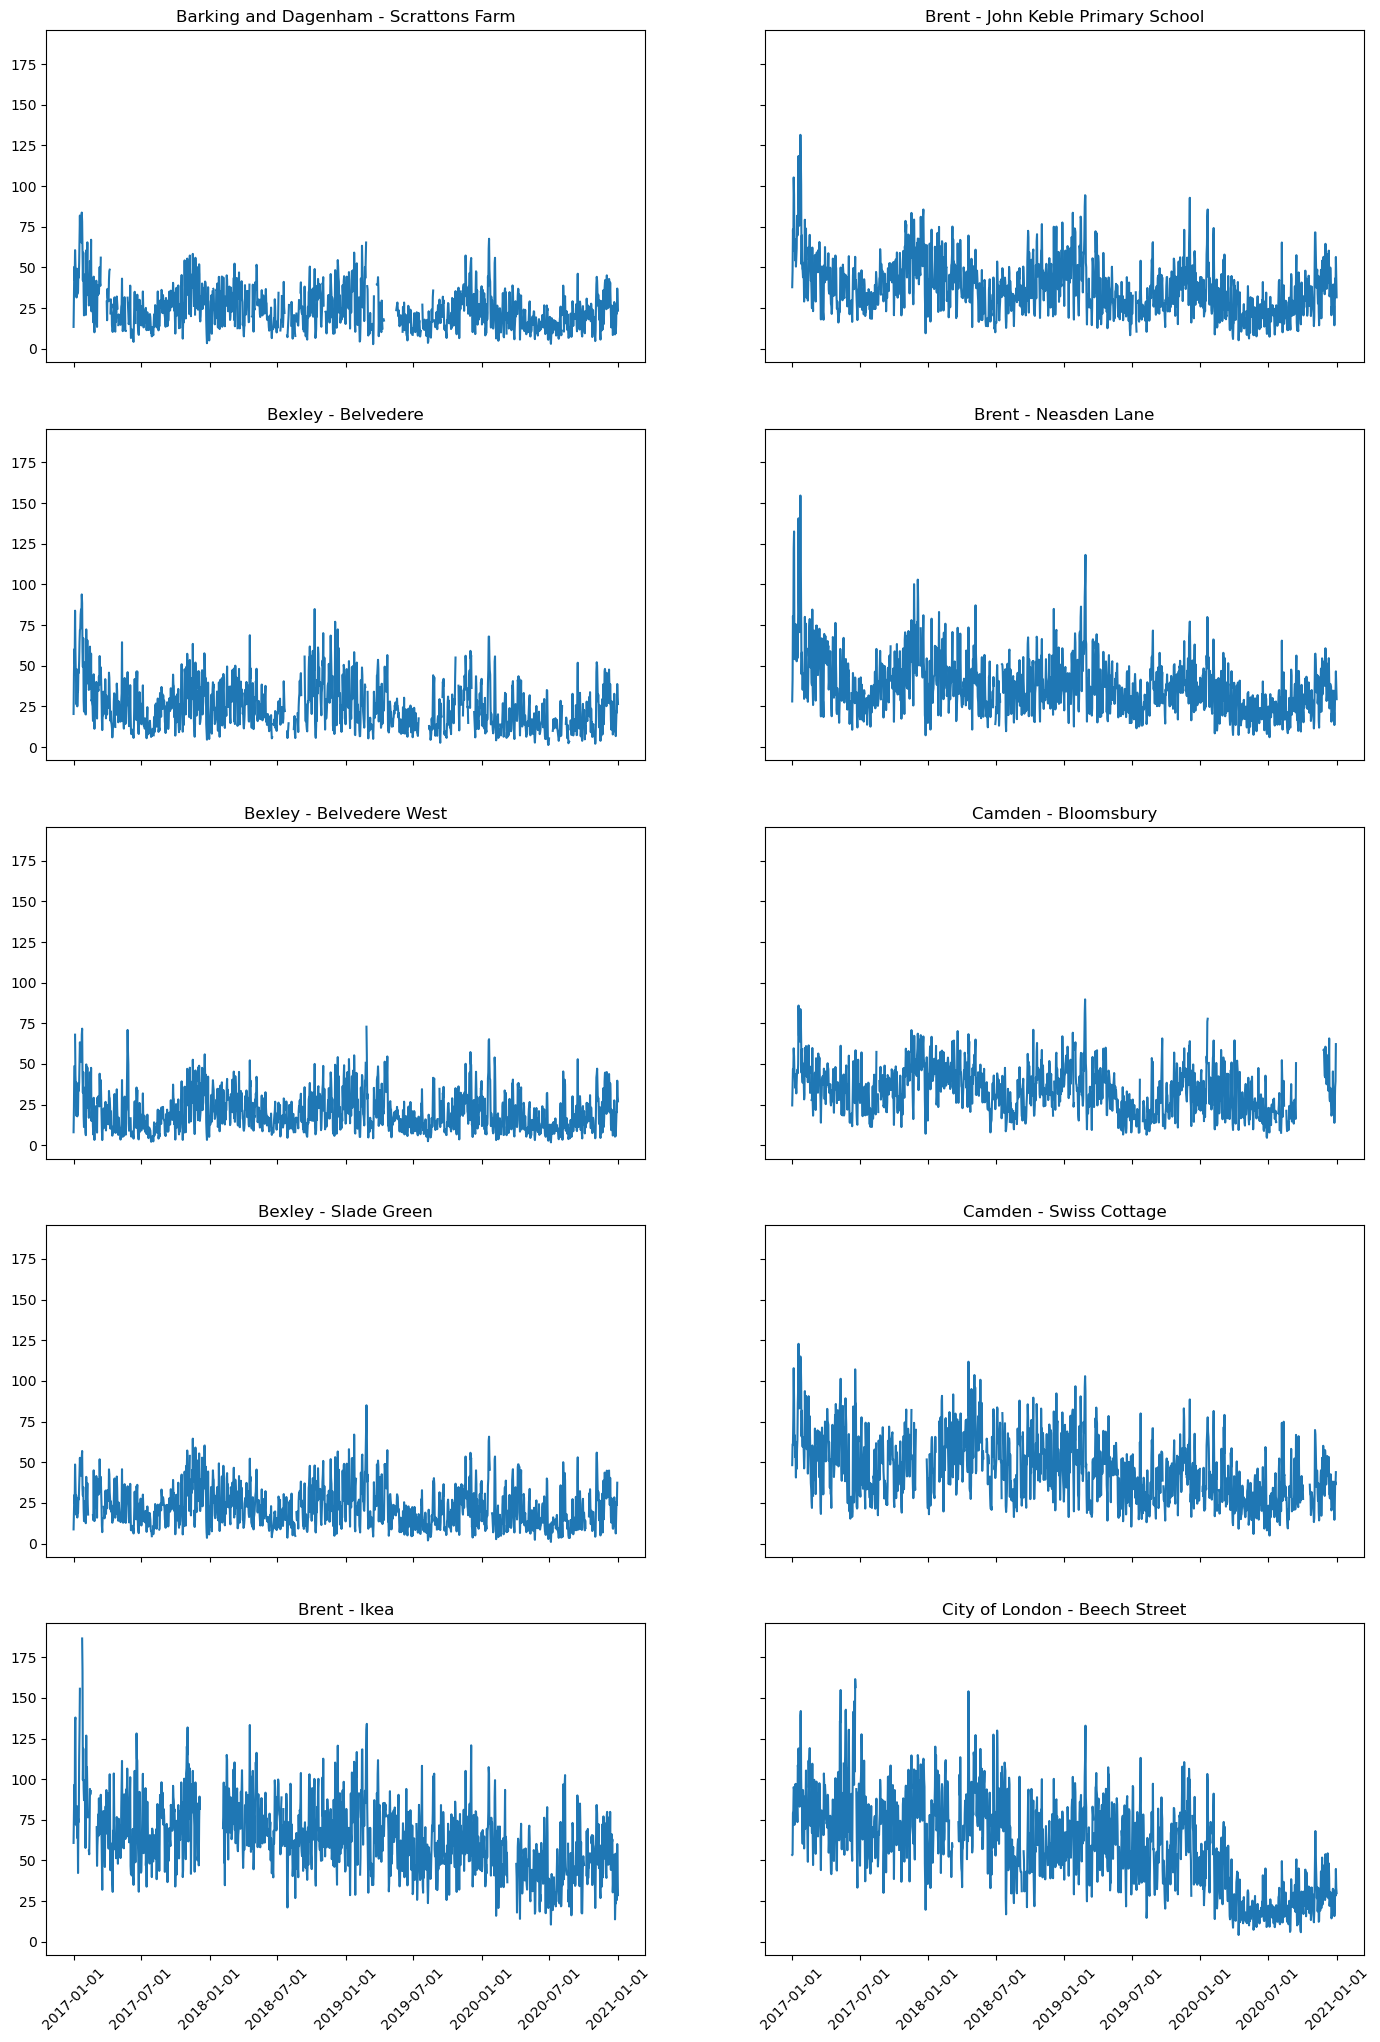

In [26]:
nrows = 5
ncols = 2
max_sites = nrows * ncols

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize = (17,25))

site_idx = 0

for site, df in df_sites_few_nan.items():
    row = site_idx % nrows
    col = site_idx // nrows
    ax[row,col].plot(df['ReadingDateTime'],df['Value'])
    ticks = ax[row,col].get_xticks()
    labels = ax[row,col].get_xticklabels()
    plt.setp(labels,rotation=45)
    ax[row,col].set_xticks(ticks)
    ax[row,col].set_title(df['site_station'].unique()[0])
    
    
    site_idx += 1
    if site_idx == max_sites:
        break

Let's look at how the remaining sites are geographically distributed throughout London.

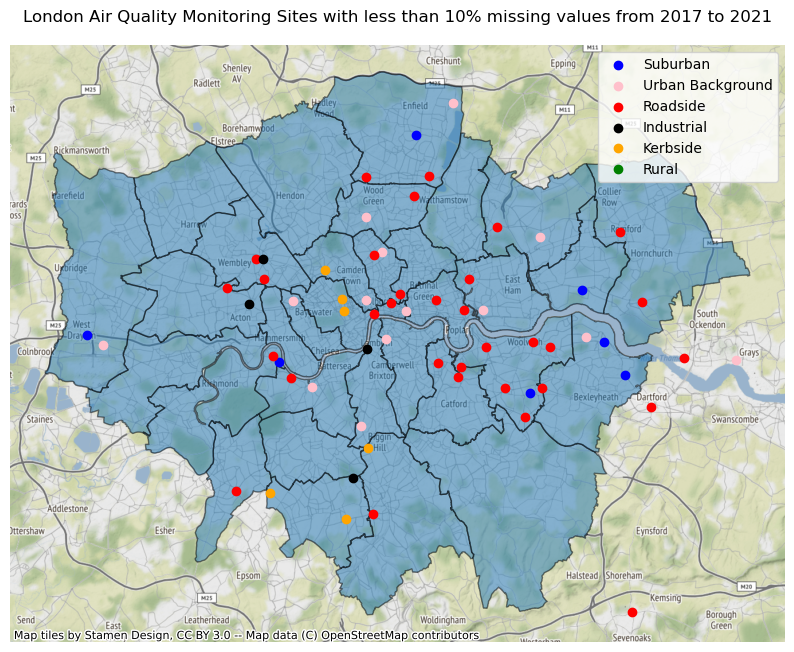

In [27]:
df_locations_few_nan = df_site_locations[df_site_locations['abbreviation'].isin(list(df_sites_few_nan.keys()))]

gdf = gpd.GeoDataFrame(df_locations_few_nan,
                       geometry = gpd.points_from_xy(df_locations_few_nan.longitude, df_locations_few_nan.latitude),
                       crs="EPSG:4326")
gdf = gdf.to_crs('EPSG:3857') #switch to web mercator coordinate system

ax = london_wm.plot(figsize = (10,10), alpha = 0.5, edgecolor = 'k')
cx.add_basemap(ax)

for class_ in classes:
    gdf_class = gdf[gdf['classification'] == class_]
    gdf_class.plot(ax = ax, color = class_colors[class_], label = class_)

plt.legend()
plt.axis('off')
plt.title(f'London Air Quality Monitoring Sites with less than {higher}% missing values from {year1} to {year2}')
plt.show()

We see that after culling sites with a large percentage of missing values, we still have a relatively wide variety of sites which are well-distributed throughout London, with a higher density toward the center of London.

With this, let's now look for outliers in our time series. To do so, we will follow the general approach of Zoest et al. (2018), who split up the time series, not only by class, but also by time period. Here, we first split up the time series by season: Winter (Dec - Feb), Spring (Mar - May), Summer (June - Aug), and Spring (Sept - Nov), and by weekday vs weekend. 

This leads to 4x2=8 temporal classes, indexed by the season and weekday vs weekend. Combined with our 6 spatial classes (roadside, curbside, etc.), we have 8x6 = 48 spatio-temporal classes. 

For each of these 48 classes, we will 
1. plot the distribution of NO2
2. sqrt the data so that the distributions look more Gaussian. 
3. Look for outliers using the z-score.
4. Transform the data back.

To do this, we will make a master Dataframe, with a new weekend column (True for dates on the weekend, else False), and a season column, which will be defined as:

* Winter (Dec - Feb): 0
* Spring (March - May): 1
* Summer (June - Aug): 2
* Fall   (Sept - Nov): 3

To achieve this, we first take the month % 12. This maps Dec to 0. Then we can take the resulting month // 3. This maps (0,1,2) --> 0, (3,4,5) --> 1, (6,7,8) --> 2, and (9,10,11) --> 3, as desired.

In [65]:
#Make master dataframe
df_list = []
for site, df in df_sites_few_nan.items():
    df_test = df.copy()
    df_test['weekend'] = df_test['ReadingDateTime'].dt.dayofweek > 4
    df_test['season'] = (df_test['ReadingDateTime'].dt.month % 12 ) // 3
    class_test = df_site_locations[df_site_locations['abbreviation'] == site]['classification'].values[0]
    df_test['class'] = class_test
    df_list.append(df_test)
    
df_master = pd.concat(df_list).reset_index(drop = True) #wipe indices clean
df_master['outlier'] = 0 #to be updated below per class

array_classes = df_master[['class','season','weekend']].drop_duplicates().to_numpy()

df_master.head()


z = 3.75 #number of standard deviations (outliers are typically >3 std deviations from the mean)
#however, here, we take a larger number for z to keep the number of outliers reasonable
season_dict = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Fall'}
weekend_dict = {False: 'weekday', True: 'weekend'}



for class_, season, weekend in array_classes:
    #print(class_, season_dict[season], weekend_dict[weekend])
    bool_df = (df_master['class'] == class_) & (df_master['season'] == season) & (df_master['weekend'] == weekend)
    
    #take sqrt of data before fitting to normal distribution
    df_sqrt = np.sqrt(df_master[bool_df].Value)
    mean = df_sqrt.mean()
    std = df_sqrt.std()
    
    outliers = (df_sqrt < mean - z*std) | (df_sqrt > mean + z*std) 
    outliers_idx_list = df_sqrt[outliers].index
    if len(outliers_idx_list) > 0:
        print(f'{len(outliers_idx_list)} outliers in ',class_, season_dict[season], weekend_dict[weekend])


    df_master.iloc[outliers_idx_list,-1] = 1


4 outliers in  Suburban Spring weekday
2 outliers in  Suburban Spring weekend
10 outliers in  Suburban Summer weekday
5 outliers in  Suburban Summer weekend
1 outliers in  Urban Background Winter weekend
3 outliers in  Urban Background Winter weekday
1 outliers in  Urban Background Summer weekday
5 outliers in  Roadside Winter weekday
3 outliers in  Roadside Spring weekday
1 outliers in  Roadside Spring weekend
12 outliers in  Roadside Summer weekday
2 outliers in  Roadside Summer weekend
1 outliers in  Industrial Winter weekday


Let's have a look at the time series with outliers.

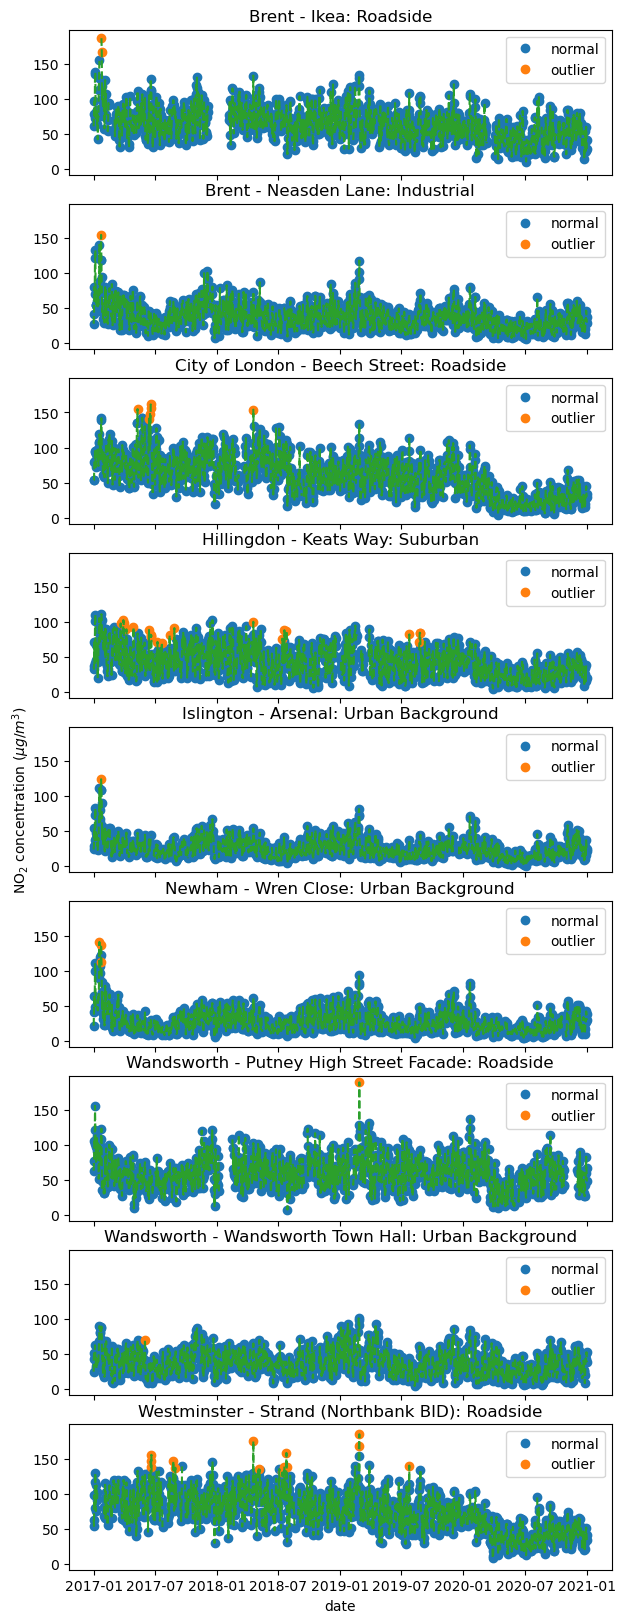

In [66]:
sites_outliers = df_master[df_master['outlier'] == 1].Site.unique()

fig, ax = plt.subplots(nrows = len(sites_outliers), ncols = 1, sharex=True, sharey = True, figsize = (7,20))

for i, site in enumerate(sites_outliers):
    
    df = df_master[df_master['Site'] == site]
    norm = df[df['outlier'] == 0]
    outliers = df[df['outlier'] == 1]

    station = df['site_station'].unique()[0]
    class_ = df['class'].unique()[0]
    

    ax[i].plot(norm['ReadingDateTime'],norm['Value'], 'o',label = 'normal')
    ax[i].plot(outliers['ReadingDateTime'], outliers['Value'], 'o',label = 'outlier')
    ax[i].plot(df['ReadingDateTime'],df['Value'],'--')
    ax[i].set_title('{}: {}'.format(station, class_))
    ax[i].legend()

set_xy_labels('date', 'NO$_2$ concentration ($\mu g/m^3$)')
#plt.legend()
#plt.setp(ax.get_xticklabels(),rotation=25)


Here, the outliers for the most part seem like real values (at least at first glance.) Our statistical analysis is highlighting days where the pollution is particularly bad. Some sites (like Hillingdon - Keats Way) have more outliers. This likely is an indicator of this site having particularly bad air quality relative to sites in the same class (here, surburban sites.)

Since these values all seem reasonable (i.e. not the result of incorrect data entry), we will not replace these outliers with NaN's. In fact, in London, these NO2 values are reviewed and "ratified." As such, we can trust that these results are meaningful. However, these outliers are still important in that they signal particularly bad air quality events.

Now, let's impute the missing values in this dataframe by replacing them with the average NO2 concentration (for the specific multiclass (classification, season, and weekend vs weekday.)

In [67]:
for class_, season, weekend in array_classes:
    bool_df = (df_master['class'] == class_) & (df_master['season'] == season) & (df_master['weekend'] == weekend)
    df_class = df_master[bool_df]
    mean = df_class.Value.mean()
    idx_nan_list = df_class[df_class['Value'].isnull()].index
    df_master.iloc[idx_nan_list,df_master.columns.get_loc('Value')] = mean

Let's now look at the remaining time series we have, separated by the type of area the site monitor is located in (i.e. roadside, urban background, etc.). For visual simplicity, we plot the monthly average of the NO2 concentration, rather than the daily average.

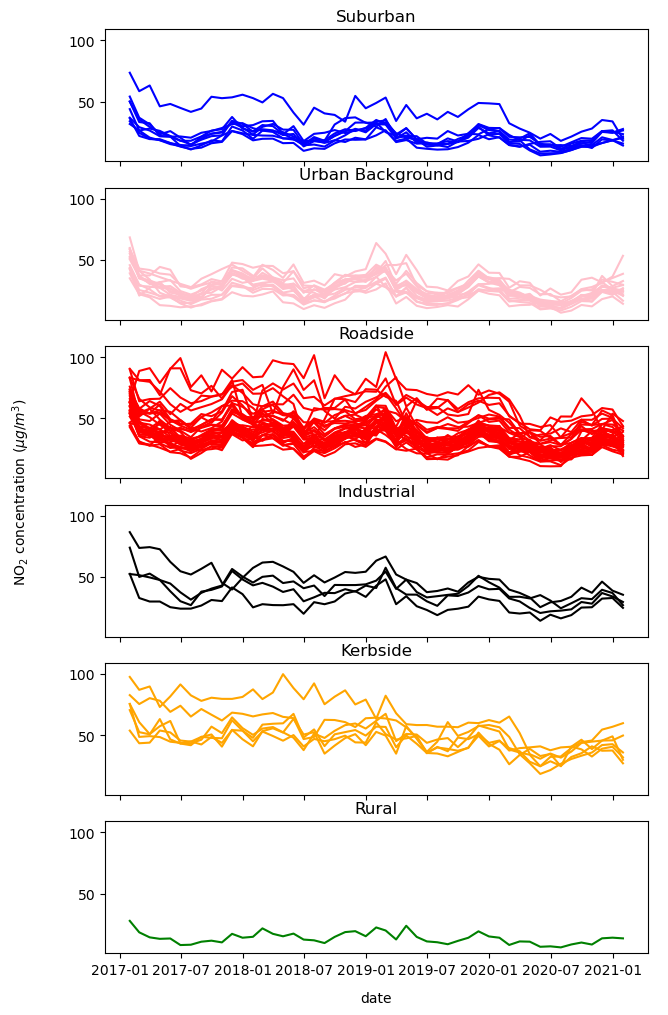

In [72]:
fig, ax = plt.subplots(nrows = len(classes), ncols = 1, sharex = True, sharey = True, figsize = (7,12))

for i, class_ in enumerate(df_master['class'].unique()):
    for site in df_master['Site'].unique():
        df = df_master[(df_master['class'] == class_) & (df_master['Site'] == site)]
        df_monthly_avg = df.set_index('ReadingDateTime').resample('M').Value.mean().reset_index()
        ax[i].plot(df_monthly_avg['ReadingDateTime'],df_monthly_avg['Value'],color = class_colors[class_])
    ax[i].set_title(class_)
    
set_xy_labels('date', 'NO$_2$ concentration ($\mu g/m^3$)', xpad = 10, ypad = 30)

From this, we see that the time series within each class have relatively similar trends! For the roadside monitors, there does seem to be a bit more variation. This may have to do with the distance of the monitor from the road. Let's check this hypothesis, by plotting the road_distance vs the average NO2 concentration for each site.

Number of sites missing distance from road: 29


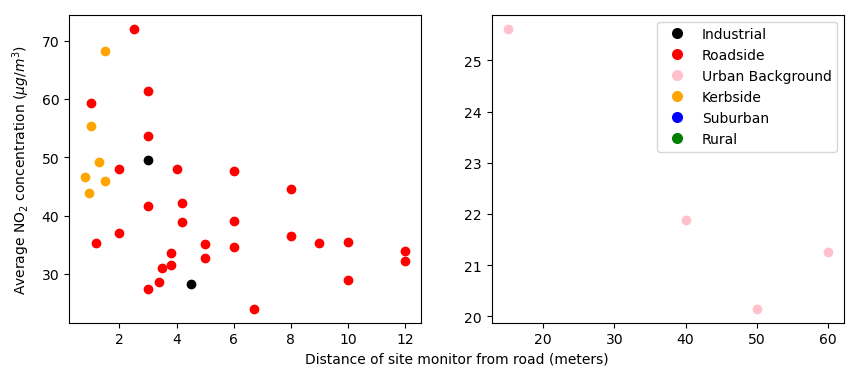

In [74]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))

num_missing_road_distance = 0
for site in df_master['Site'].unique():
    road_distance = df_locations_few_nan.loc[df_locations_few_nan['abbreviation'] == site,'road_distance'].values[0]
    if not np.isnan(road_distance):
        df_site = df_master[df_master['Site'] == site]
        
        class_site = df_site['class'].unique()[0]
        df_avg = df_site.Value.mean()
        if class_site != 'Urban Background':
            ax[0].plot(road_distance,df_avg,'o',color = class_colors[class_site])
        else:
            ax[1].plot(road_distance,df_avg,'o',color = class_colors[class_site])
    else:
        num_missing_road_distance += 1
        
print(f'Number of sites missing distance from road: {num_missing_road_distance}')

legend_elements = [legend_element(color,label, size = 9) for label, color in class_colors.items()]
ax[1].legend(legend_elements, class_colors.keys())

set_xy_labels('Distance of site monitor from road (meters)','Average NO$_2$ concentration ($\mu g/m^3$)');

As expected, generally, the farther a site monitor is from the road, the lower the NO2 concentration is. This is for the Industrial, Roadside, and Curbside classes. The Urban Background sites seem to be so far away from the road that the NO2 concentration has evened out. The Surburban sites do not have data for the distance from the road, but likely behave as the Urban Background sites. The single rural site also does not have data for the distance from the road.

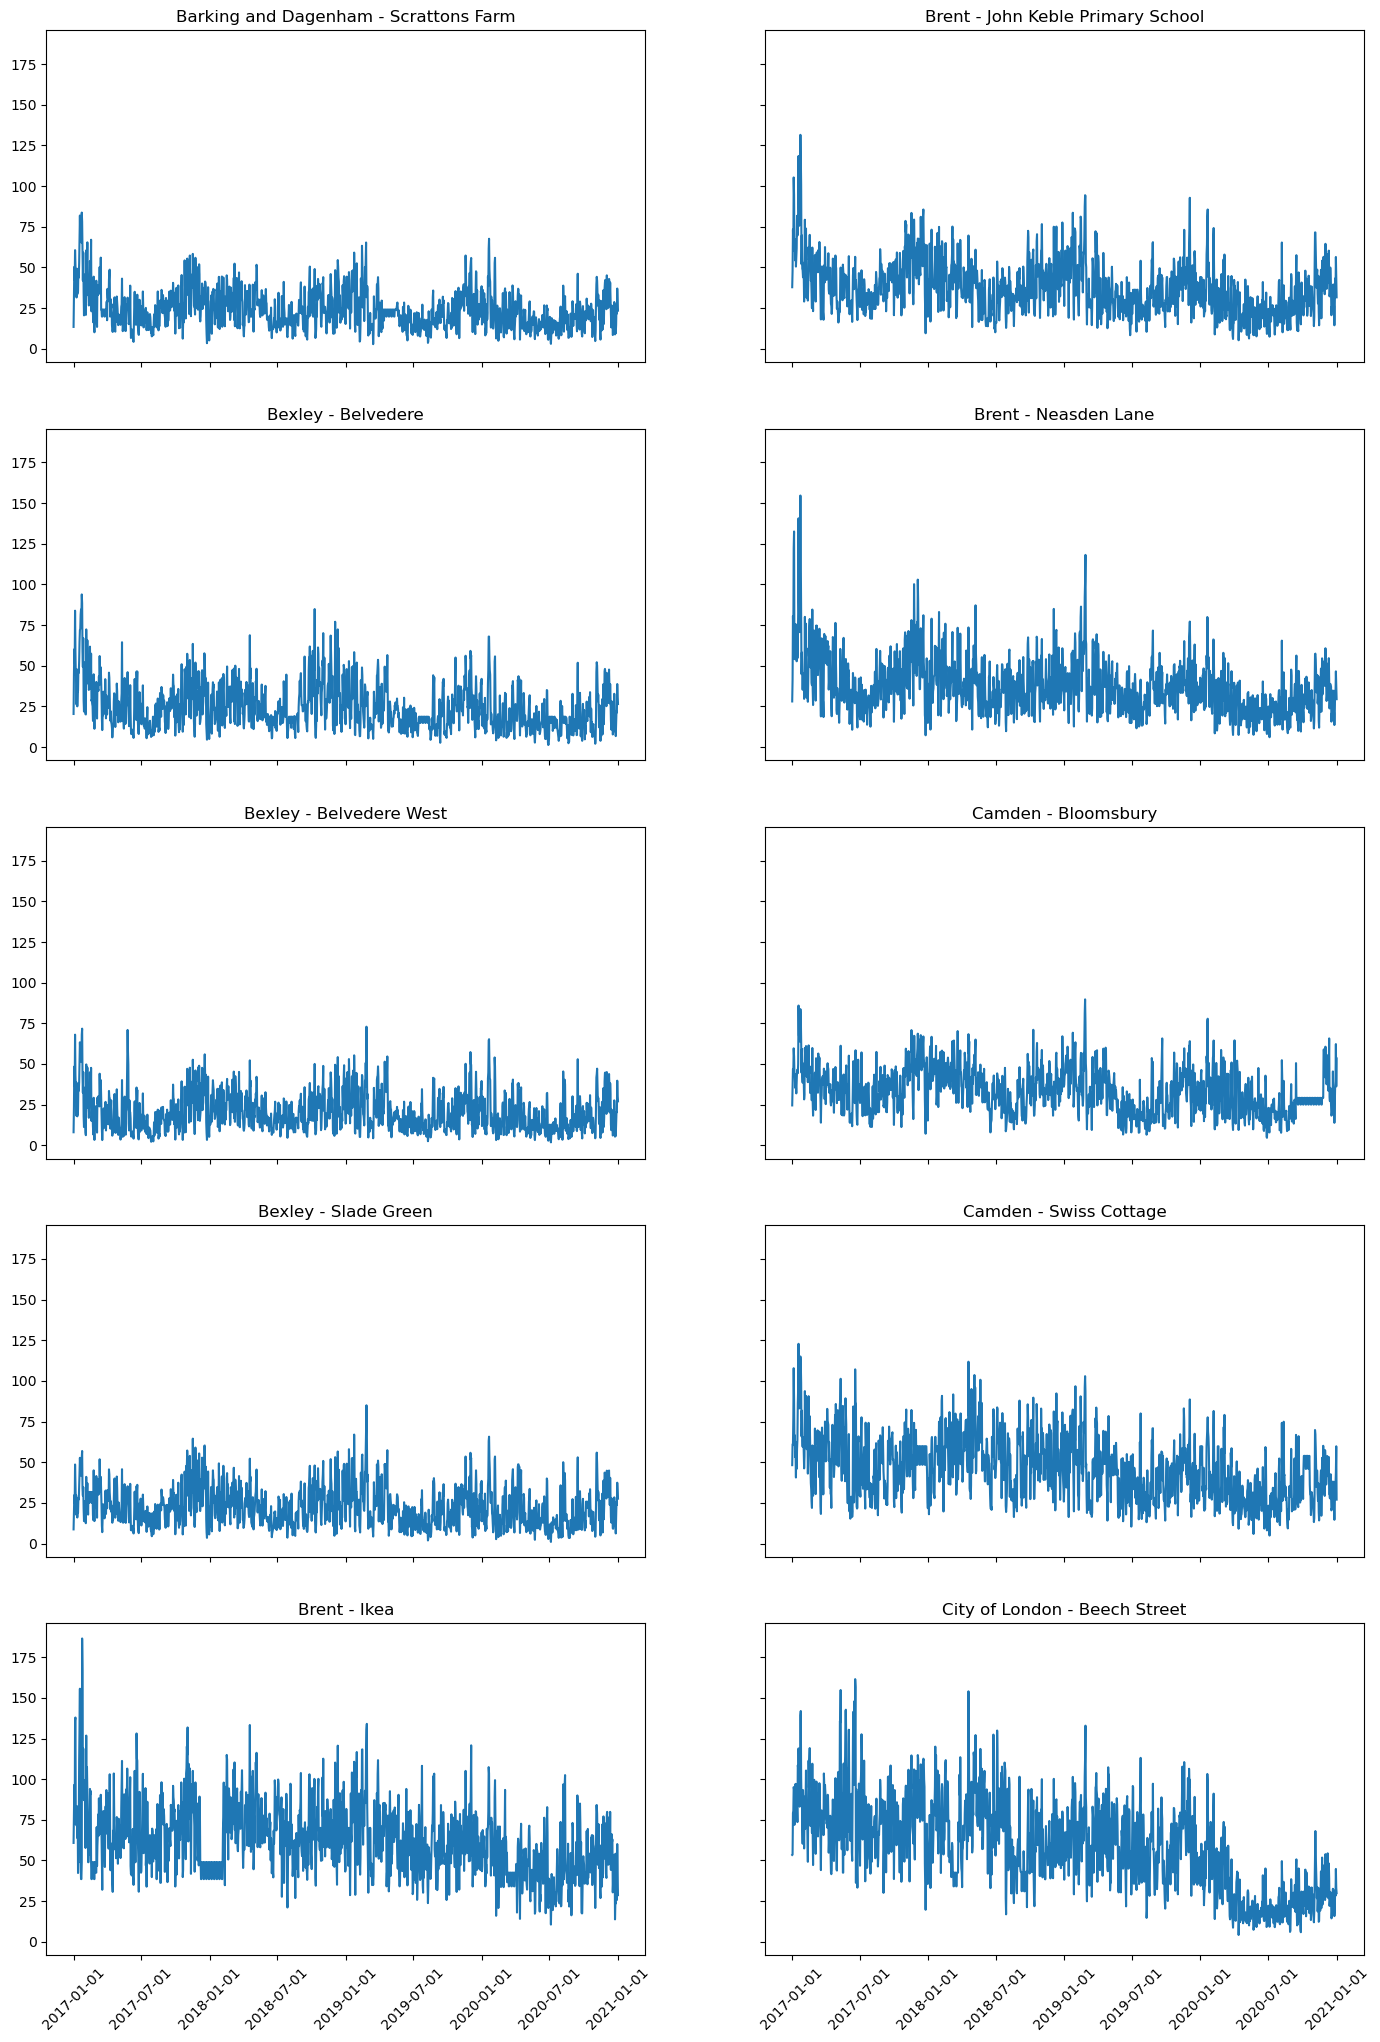

In [75]:
nrows = 5
ncols = 2
max_sites = nrows * ncols

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize = (17,25))

site_idx = 0

for site in df_master['Site'].unique():
    row = site_idx % nrows
    col = site_idx // nrows
    
    df = df_master[df_master['Site'] == site]
    
    ax[row,col].plot(df['ReadingDateTime'],df['Value'])
    ticks = ax[row,col].get_xticks()
    labels = ax[row,col].get_xticklabels()
    plt.setp(labels,rotation=45)
    ax[row,col].set_xticks(ticks)
    ax[row,col].set_title(df['site_station'].unique()[0])
    
    
    site_idx += 1
    if site_idx == max_sites:
        break

Note that it is very clear where we imputed values. In the future, we will try to impute the missing values using a k-nearest-neighbors approach. For now, let's simply combine the time series together into one dataframe.

In [76]:
dfs_to_be_merged = []

for site in df_master['Site'].unique():
    df = df_master[df_master['Site'] == site]
    df_NO2 = df.rename(columns = {'ReadingDateTime': 'time','Value': site})
    dfs_to_be_merged.append(df_NO2[['time',site]].copy())
    
#initialize df_master, which will be the concatenation of all the df's
df_master = dfs_to_be_merged[0]

for idx in range(1,len(dfs_to_be_merged)):
    df_master = df_master.merge(dfs_to_be_merged[idx], on = 'time')

df_master.head()

time   BG2   BX2        BQ7   BX1    BT4    BT6    BT5   BL0    CD1  \
0 2017-01-01  13.4  20.3   8.000000   8.7   60.8   37.8   28.0  24.5   48.2   
1 2017-01-02  32.4  44.8  23.700000  20.0   79.1   47.8   41.4  34.5   61.0   
2 2017-01-03  50.3  60.1  48.400000  29.8   96.5   73.3   80.5  46.9   61.0   
3 2017-01-04  42.1  51.5  36.167726  24.7   72.5   61.9   69.8  45.8   77.3   
4 2017-01-05  60.6  83.8  68.000000  48.6  136.0  105.3  122.1  59.6  107.8   

   ...    TH4   TH2    WA8   WA2    MY1   WM6    NB1   MW4   MW2   MW1  
0  ...   40.2  41.4   63.2  25.2   60.4  56.7   62.5   9.8  19.0  27.9  
1  ...   61.3  57.3   77.6  51.4   50.2  55.3   53.8  19.8  32.4  32.6  
2  ...   71.5  72.7  105.1  43.7  107.6  92.7   98.0  31.8  41.8  56.0  
3  ...   73.7  73.1  100.9  43.5   74.0  82.2   78.8  22.8  41.7  43.6  
4  ...  112.6  99.3  155.7  62.8   93.5  95.6  116.6  58.5  90.4  81.6  

[5 rows x 71 columns]

With this, we now have a dataframe storing our multivariate time series that we can use to make predictions.

In [78]:
df_master.to_csv('df_parsed_lin.csv')

Now, let's impute the missing values using a nearest-neighbor approach.

### Test k-nearest neighbors imputation

In [36]:
#define distance function between two points

"""
For each site (column), find its k nearest-neighbor sites of the same type. Use that data for imputation.
To avoid redundant calculation, calculate the distance matrix from the beginning.
"""

'\nFor each site (column), find its k nearest-neighbor sites of the same type. Use that data for imputation.\nTo avoid redundant calculation, calculate the distance matrix from the beginning.\n'